In [2]:

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

import tensorflow_datasets as tfds


ModuleNotFoundError: No module named 'tensorflow_datasets'

In [ ]:
dataset, info = tfds.load('celeb_a', with_info=True)
full_dataset = dataset['train']

total_samples = info.splits['train'].num_examples
train_size = int(0.8 * total_samples)

full_dataset = full_dataset.shuffle(1000, seed=42)
train_dataset = full_dataset.take(train_size)
val_dataset = full_dataset.skip(train_size)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/celeb_a/incomplete.FLXMXJ_2.1.0/celeb_a-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/celeb_a/incomplete.FLXMXJ_2.1.0/celeb_a-validation.tfrecord*...:   0%|    …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/celeb_a/incomplete.FLXMXJ_2.1.0/celeb_a-test.tfrecord*...:   0%|          …

Dataset celeb_a downloaded and prepared to /root/tensorflow_datasets/celeb_a/2.1.0. Subsequent calls will reuse this data.


In [ ]:
image_size = 128
batch_size = 32

def preprocess(features):
    image = features['image']
    smiling = features['attributes']['Smiling']  # 0 or 1
    image = tf.image.resize(image, (image_size, image_size))
    image = tf.cast(image, tf.float32) / 255.0  # normalize
    return image, smiling

train_dataset = train_dataset.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)



(32, 128, 128, 3) (32,)


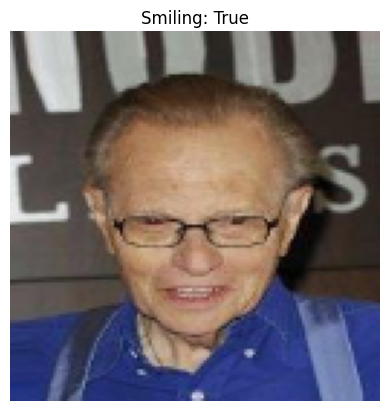

In [ ]:
# Test the dataset
for images, labels in train_dataset.take(1):
    print(images.shape, labels.shape)

    plt.imshow(images[0].numpy())  # convert to numpy array
    plt.title(f"Smiling: {labels[0].numpy()}")
    plt.axis('off')
    plt.show()

In [ ]:

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(image_size, image_size, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # sigmoid for binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     6,422,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,515,905 (24.86 MB)

 Trainable params: 6,515,905 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

CALLBACKS = [
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=0.01, min_lr=1e-10, patience=2, verbose=1, mode='auto'),
    EarlyStopping(monitor='val_accuracy', patience=8, min_delta=0.01, restore_best_weights=True, verbose=1)
]

steps_per_epoch = len(train_dataset)
validation_steps = len(val_dataset)

In [ ]:
with tf.device('/GPU:0'):
  epochs = 10
  history = model.fit(train_dataset,
                      epochs=epochs,
                      validation_data=val_dataset,
                      batch_size=batch_size,
                      callbacks=CALLBACKS,
                      validation_steps=validation_steps,
                      steps_per_epoch=steps_per_epoch
                      )

In [1]:
model.load_weights("model.weights.h5")

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Weights loaded successfully!")

NameError: name 'model' is not defined

In [26]:
model.save_weights("model.weights.h5")

In [ ]:

# plots for accuracy and Loss with epochs

error = pd.DataFrame(history.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

In [ ]:
# Define class names
class_names = {0: "no smile", 1: "smile"}

# Take one batch from the dataset
for images, labels in train_dataset.take(1):  # first batch
    preds = model.predict(images)        # model output probabilities
    y_pred = (preds > 0.5).astype(int).flatten()  # Convert probs → binary labels
    y_true = labels.numpy().astype(int).flatten() # Convert to numpy ints

    num_images = min(len(images), 10)

    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        img = images[i].numpy()
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(
            f"Pred: {class_names[y_pred[i]]}\nTrue: {class_names[y_true[i]]}",
            fontsize=12,
            color='green' if y_pred[i] == y_true[i] else 'red'
        )
        plt.axis("off")
    plt.show()
    break


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
from PIL import Image

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
      async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = '📸 Capture';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        // Resize output to fit the video
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        // Wait for capture button
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getTracks().forEach(track => track.stop());
        div.remove();

        const data = canvas.toDataURL('image/jpeg', quality);
        return data;
      }
      takePhoto(%f);
    ''' % quality)

    display(js)
    data = eval_js('takePhoto(%f)' % quality)
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

In [ ]:
filename = take_photo()
print("Saved to", filename)

# Display the captured image
img = Image.open(filename)
display(img)

In [ ]:
img = Image.open(filename).resize((128, 128))
img_array = np.array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)  # add batch dimension

pred = model.predict(img_array)
label = "smile" if pred[0] > 0.5 else "no smile"

plt.imshow(img)
plt.title(f"Prediction: {label}")
plt.axis("off")
plt.show()